# 1. Importing Data 

In [1]:
import pandas as pd 
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('data/dataset.csv')
df.head()

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000


In [3]:
df.Store.unique()

array(['LOS_ANGELES', 'SAN_FRANCISCO'], dtype=object)

In [4]:
df.Product.unique()

array(['TESLA_MODEL_X', 'TESLA_MODEL_S'], dtype=object)

In [5]:
df = df[(df['Product']=='TESLA_MODEL_X') & (df['Store']=='LOS_ANGELES')]
df.head()

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000


In [6]:
df.Store.unique()

array(['LOS_ANGELES'], dtype=object)

In [7]:
df.Product.unique()

array(['TESLA_MODEL_X'], dtype=object)

# 2. Preprocess and Create Partitions

## (i) Create Dates

In [8]:
df.head()

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000


In [9]:
df['ds'] = pd.to_datetime(df.Date, format='%Y%m%d')

In [10]:
df['day'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year

In [11]:
df = df.drop(['Date','Store','Product','day','month','year'], axis=1)

In [12]:
df.columns = ['y','ds']

In [13]:
df.dtypes

y            float64
ds    datetime64[ns]
dtype: object

In [14]:
df.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


## (ii) Visualise the Data to Determine Appropriate Partitions

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

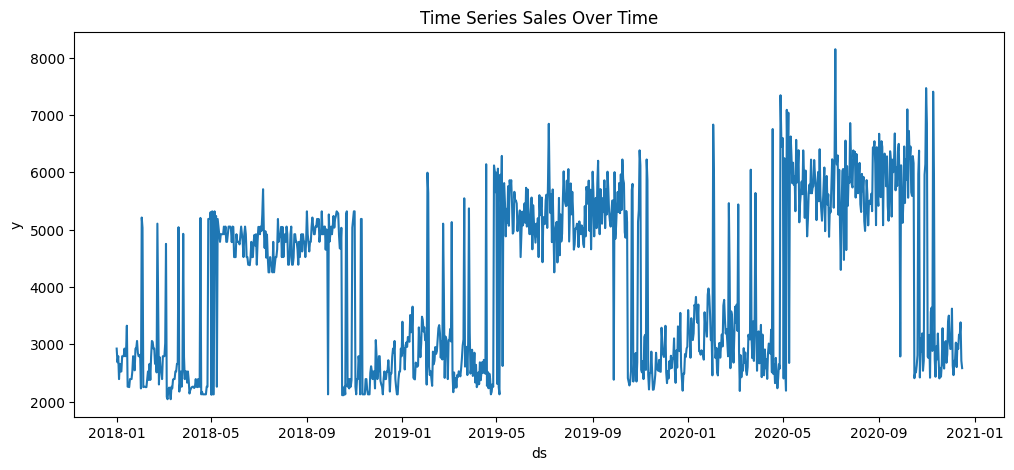

In [16]:
plt.figure(figsize=(12,5))
sns.lineplot(x='ds', y='y', data=df).set_title('Time Series Sales Over Time')
plt.show()

## (iii) Create Train and Test Splits

In [17]:
df['ds'].min()

Timestamp('2018-01-01 00:00:00')

In [18]:
df['ds'].max()

Timestamp('2020-12-16 00:00:00')

In [19]:
train = df[df['ds'] < '2020-06-30 00:00:00']
test = df[df['ds'] >= '2020-06-30 00:00:00']

In [20]:
train.shape

(910, 2)

In [21]:
test.shape

(170, 2)

In [22]:
170/(910+170)

0.1574074074074074

# 3. Train Model

In [23]:
from prophet import Prophet 

In [24]:
m = Prophet()
model = m.fit(train)

20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing


# 4. Evaluate Model

## (i) Make Predictions on Test Set

In [25]:
from sklearn.metrics import mean_absolute_error

In [26]:
yhat = m.predict(test[['ds']])

In [27]:
yhat.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-30,4355.772735,4473.251253,6414.204757,4355.772735,4355.772735,1113.304933,1113.304933,1113.304933,-7.935457,-7.935457,-7.935457,1121.240390,1121.240390,1121.240390,0.0,0.0,0.0,5469.077668
1,2020-07-01,4356.717916,4467.156531,6456.668438,4356.717916,4356.717916,1099.109473,1099.109473,1099.109473,-13.477089,-13.477089,-13.477089,1112.586562,1112.586562,1112.586562,0.0,0.0,0.0,5455.827389
2,2020-07-02,4357.663096,4489.799075,6511.110154,4357.663096,4357.663096,1121.363697,1121.363697,1121.363697,15.737098,15.737098,15.737098,1105.626599,1105.626599,1105.626599,0.0,0.0,0.0,5479.026793
3,2020-07-03,4358.608277,4388.840730,6391.416727,4358.608277,4358.608277,1061.177602,1061.177602,1061.177602,-39.351680,-39.351680,-39.351680,1100.529282,1100.529282,1100.529282,0.0,0.0,0.0,5419.785879
4,2020-07-04,4359.553457,4415.467941,6442.328350,4359.553457,4359.553457,1071.485992,1071.485992,1071.485992,-25.910925,-25.910925,-25.910925,1097.396917,1097.396917,1097.396917,0.0,0.0,0.0,5431.039449


In [28]:
mean_absolute_error(test[['y']], yhat[['yhat']])

702.3628478731841

## (ii) Make New Predictions

In [29]:
test.tail()

,y,ds
1075,3167.594500,2020-12-12
1076,3167.594500,2020-12-13
1077,3383.354511,2020-12-14
1078,2714.591329,2020-12-15
1079,2585.035107,2020-12-16


In [30]:
future = m.make_future_dataframe(periods=1000, freq='D')
forecast = m.predict(future) 
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1905,2023-03-22,5296.227455,3332.414300,5289.470099,5296.088683,5296.379031,-984.944595,-984.944595,-984.944595,-13.477089,-13.477089,-13.477089,-971.467506,-971.467506,-971.467506,0.0,0.0,0.0,4311.282859
1906,2023-03-23,5297.172635,3371.621448,5339.653660,5297.033634,5297.324538,-944.200625,-944.200625,-944.200625,15.737098,15.737098,15.737098,-959.937723,-959.937723,-959.937723,0.0,0.0,0.0,4352.972011
1907,2023-03-24,5298.117816,3289.966164,5276.448973,5297.978555,5298.269938,-990.645687,-990.645687,-990.645687,-39.351680,-39.351680,-39.351680,-951.294007,-951.294007,-951.294007,0.0,0.0,0.0,4307.472129
1908,2023-03-25,5299.062997,3371.893536,5361.651786,5298.923471,5299.215338,-972.049711,-972.049711,-972.049711,-25.910925,-25.910925,-25.910925,-946.138786,-946.138786,-946.138786,0.0,0.0,0.0,4327.013286
1909,2023-03-26,5300.008177,3372.231123,5316.837273,5299.868437,5300.160738,-897.294487,-897.294487,-897.294487,47.692912,47.692912,47.692912,-944.987399,-944.987399,-944.987399,0.0,0.0,0.0,4402.713690


In [31]:
future.tail()

,ds
1905,2023-03-22
1906,2023-03-23
1907,2023-03-24
1908,2023-03-25
1909,2023-03-26


In [32]:
forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail()

,ds,yhat_lower,yhat,yhat_upper
1905,2023-03-22,3332.414300,4311.282859,5289.470099
1906,2023-03-23,3371.621448,4352.972011,5339.653660
1907,2023-03-24,3289.966164,4307.472129,5276.448973
1908,2023-03-25,3371.893536,4327.013286,5361.651786
1909,2023-03-26,3372.231123,4402.713690,5316.837273


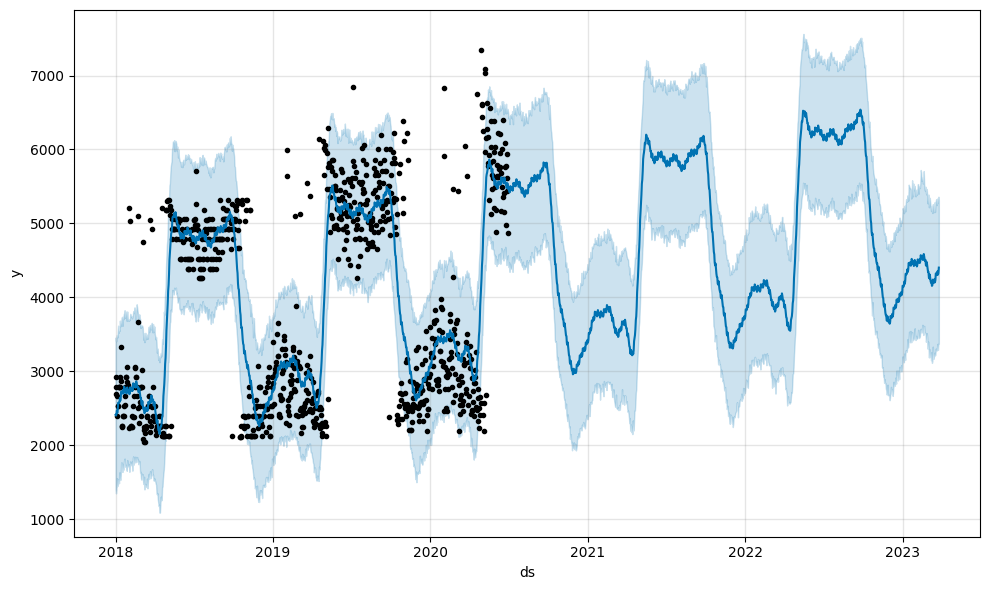

In [33]:
plot1 = m.plot(forecast)

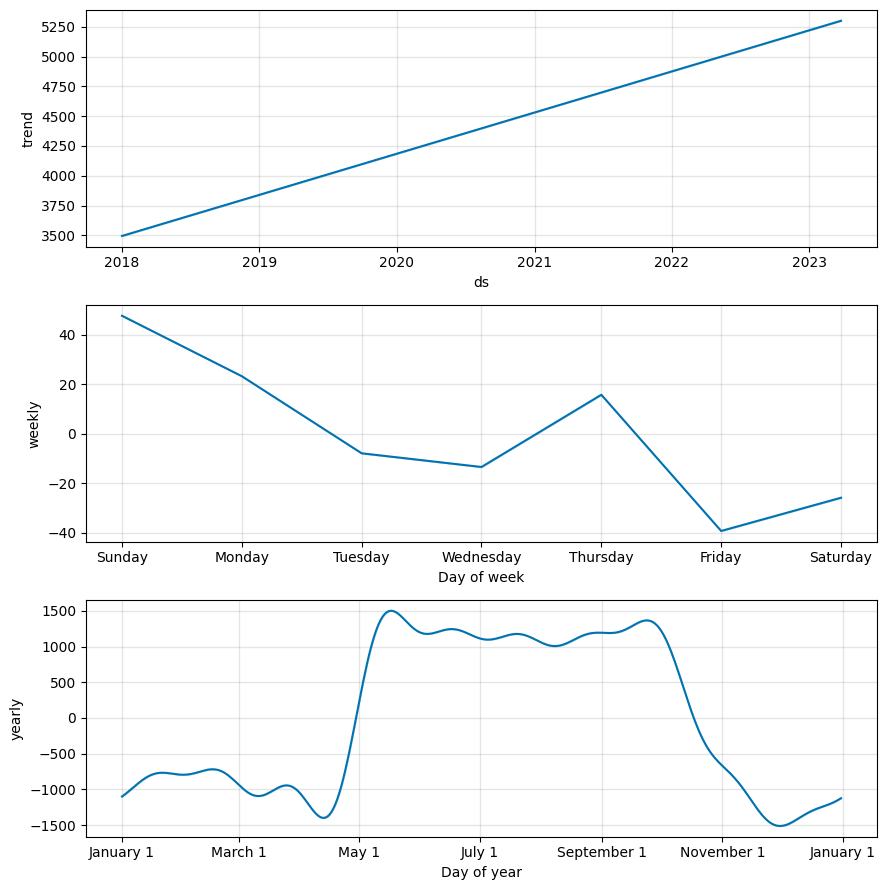

In [34]:
plot2 = m.plot_components(forecast)

# 5. Save Model

In [35]:
import json
from prophet.serialize import model_to_json, model_from_json

In [36]:
with open('models/serialized_model.json', 'w') as fout: 
    json.dump(model_to_json(m), fout)

In [37]:
del m

In [38]:
with open('models/serialized_model.json', 'r') as fin: 
    m = model_from_json(json.load(fin))

In [39]:
future = m.make_future_dataframe(periods=100, freq='D')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1005,2020-10-03,4445.564894,4518.496141,6514.776898,4445.561208,4445.568797,1079.449218,1079.449218,1079.449218,-25.910925,-25.910925,-25.910925,1105.360143,1105.360143,1105.360143,0.0,0.0,0.0,5525.014112
1006,2020-10-04,4446.510075,4490.009228,6561.893658,4446.506325,4446.514054,1093.301856,1093.301856,1093.301856,47.692912,47.692912,47.692912,1045.608944,1045.608944,1045.608944,0.0,0.0,0.0,5539.811930
1007,2020-10-05,4447.455255,4438.838836,6405.018576,4447.451433,4447.459277,1003.637992,1003.637992,1003.637992,23.245142,23.245142,23.245142,980.392850,980.392850,980.392850,0.0,0.0,0.0,5451.093247
1008,2020-10-06,4448.400436,4364.933394,6377.932075,4448.396554,4448.404496,902.287356,902.287356,902.287356,-7.935457,-7.935457,-7.935457,910.222813,910.222813,910.222813,0.0,0.0,0.0,5350.687792
1009,2020-10-07,4449.345617,4266.025749,6314.419585,4449.341665,4449.349718,822.219858,822.219858,822.219858,-13.477089,-13.477089,-13.477089,835.696947,835.696947,835.696947,0.0,0.0,0.0,5271.565474


# 6. Create models for each combo

## (i) Process Entire Dataframe

In [40]:
df = pd.read_csv('data/dataset.csv')

In [41]:
df['ds'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [42]:
df.head()

,Date,Store,Product,Value,ds
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000,2018-01-01
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531,2018-01-02
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000,2018-01-03
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000,2018-01-04
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000,2018-01-05


## (ii) Create Model Building Function

In [43]:
def build_model(df, product, store): 
    # Filter dataframe on a specific product and store
    abt = df[(df['Product']==product) & (df['Store']==store)]
    abt = abt.drop(['Date','Store','Product'], axis=1) 
    abt.columns = ['y','ds']
    
    # Fit the prophet model on all the data 
    m = Prophet()
    model = m.fit(abt) 
    
    # Save Model 
    with open(f'models/serialized_model_{product}_{store}.json', 'w') as fout: 
        json.dump(model_to_json(m), fout)
    
    return f'Model fit for {product} and {store}'

In [44]:
build_model(df, 'TESLA_MODEL_X', 'SAN_FRANCISCO')

20:24:06 - cmdstanpy - INFO - Chain [1] start processing
20:24:07 - cmdstanpy - INFO - Chain [1] done processing


'Model fit for TESLA_MODEL_X and SAN_FRANCISCO'

In [45]:
with open('models/serialized_model_TESLA_MODEL_X_SAN_FRANCISCO.json', 'r') as fin: 
    reloaded_model = model_from_json(json.load(fin))

In [46]:
refuture = reloaded_model.make_future_dataframe(periods=1000, freq='D')
reforecast = reloaded_model.predict(refuture)

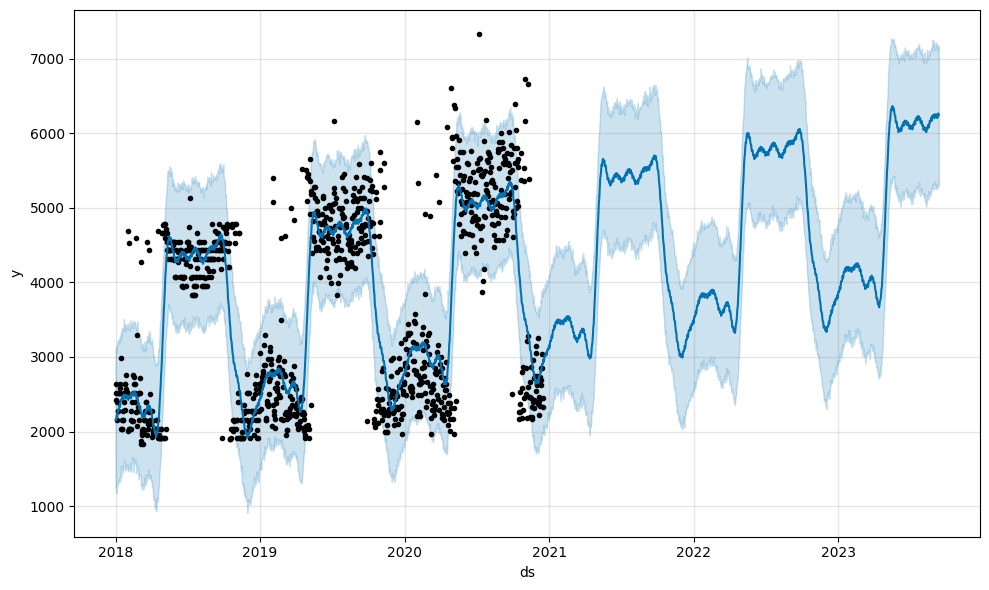

In [47]:
plotx = reloaded_model.plot(reforecast)

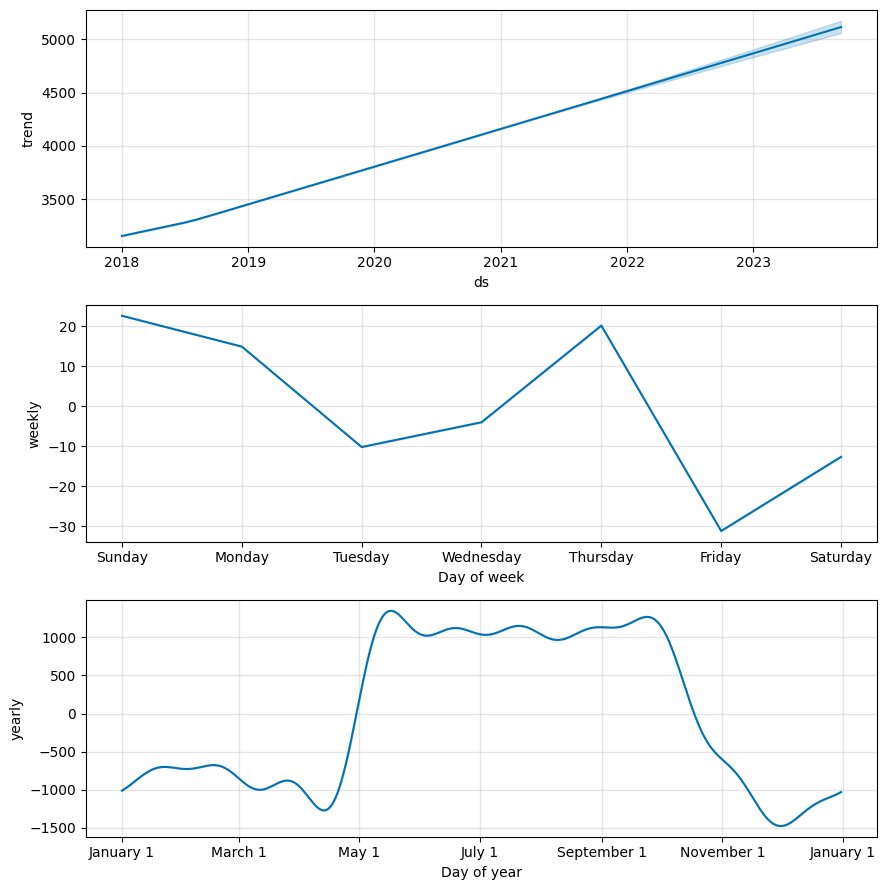

In [48]:
plot1 = reloaded_model.plot_components(reforecast)

## (iii) Loop Through All the Store and Vehicle Combinations

In [49]:
import itertools

In [50]:
display(df['Store'].unique(), df['Product'].unique())

array(['LOS_ANGELES', 'SAN_FRANCISCO'], dtype=object)

array(['TESLA_MODEL_X', 'TESLA_MODEL_S'], dtype=object)

In [51]:
for product, store in itertools.product(df['Product'].unique(), df['Store'].unique()):
    print(build_model(df, product, store))

20:24:10 - cmdstanpy - INFO - Chain [1] start processing
20:24:10 - cmdstanpy - INFO - Chain [1] done processing


Model fit for TESLA_MODEL_X and LOS_ANGELES


20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:11 - cmdstanpy - INFO - Chain [1] done processing


Model fit for TESLA_MODEL_X and SAN_FRANCISCO


20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:11 - cmdstanpy - INFO - Chain [1] done processing


Model fit for TESLA_MODEL_S and LOS_ANGELES


20:24:12 - cmdstanpy - INFO - Chain [1] start processing
20:24:12 - cmdstanpy - INFO - Chain [1] done processing


Model fit for TESLA_MODEL_S and SAN_FRANCISCO


In [52]:
with open('models/serialized_model_TESLA_MODEL_S_LOS_ANGELES.json', 'r') as fin: 
    reloaded_model = model_from_json(json.load(fin))

In [53]:
future = reloaded_model.make_future_dataframe(periods=120, freq='D')
forecast = reloaded_model.predict(future)

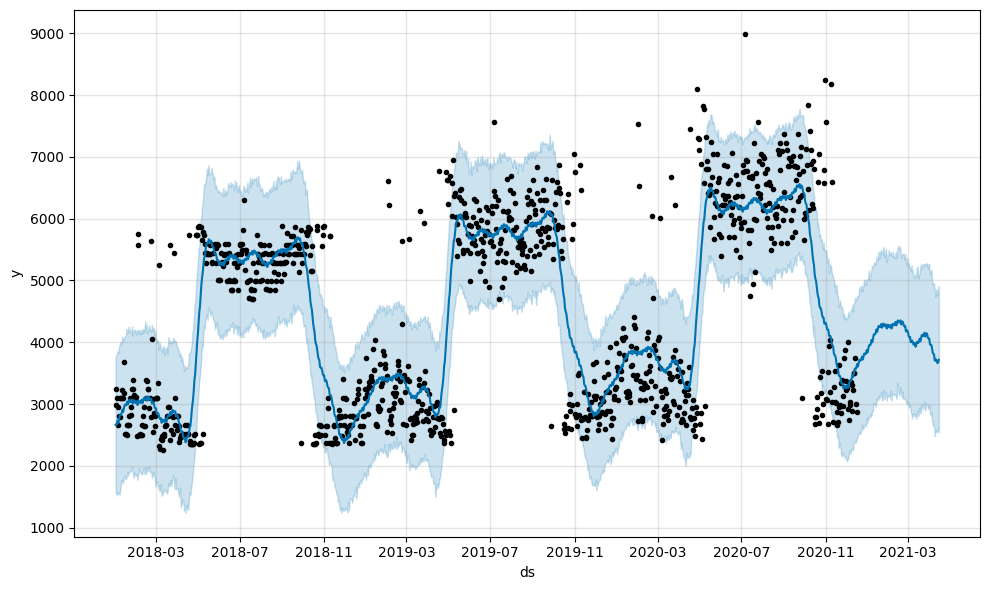

In [54]:
p = reloaded_model.plot(forecast)

# Notebook Ends Here